In [7]:
import importlib
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns
from torchvision.ops.misc import interpolate
from tqdm.notebook import tqdm as tqdm_notebook

#### Custum libraries
import lib.algos_maxRSA as max_rsa
import lib.utils_RSA as rsa
import lib.utils_CKA as cka
from lib.algos import *
from scipy.spatial import procrustes as scipro

from lib.algos_maxRSA import find_max_dissimilarity_images

importlib.reload(rsa)
importlib.reload(cka)
importlib.reload(max_rsa)

<module 'lib.algos_maxRSA' from '/home/alban/projects/SAYCam_Vs_EGO4D/lib/algos_maxRSA.py'>

In [8]:
dataset = 'imagenetVal'
#models  = ['ego', 'saycam', 'imagenet', 'supervised', 'random', 'resnet']
models  = ['ego', 'saycam']
path2activations = f'/home/alban/Documents/activations_datadriven/%s_{dataset}/'

imagelists = {}
activations = {}
for model in models:
    with open(join(path2activations%model, 'imagepaths.txt'), 'r') as f:
        imagelists[model] = [line.strip() for line in f.readlines()]
    activations[model] = np.load(join(path2activations % model, 'cls_tokens.npy'))

activations[model].shape

(50000, 768)

In [9]:
#### Normalize vectors
for model in models:
    norms = np.linalg.norm(activations[model], axis=1, keepdims=True)
    activations[model] = activations[model]/norms # normalization

In [10]:
#### Compute RDMs performing squared euclidean distance as a metric (to be equivalent to CKA methods, cf. Williams, 2024)
RDMs = {}

metric = 'L2squared'
for i, model in enumerate(models):
    print(model)
    RDMs[model] = rsa.compute_RDMs(activations[model], metric = metric, display = False, title = f'{model}_{metric}')
    #RDMs[model] = cka.centering(RDMs[model]) # same as centering with matmul


ego
saycam


In [11]:

SIMs_saycam_ego = np.float64(0.6297048936065802) # or 0.649# already computed



In [12]:
### check if images were shown in the same order
assert imagelists['ego'] == imagelists['saycam']
imagelist = imagelists['ego'] # since they are the same, only consider one list

#### check if each category has the same number of images and list all categories in listcats
count = 0
cat = ''
listcat = list()
for i, imgp in enumerate(imagelist):
    current_cat = imgp.split('/')[-2]
    if i == 0:
        cat = current_cat
        listcat.append(current_cat)
    if cat != current_cat:
        cat = current_cat
        listcat.append(current_cat)
        count = 1
    else:
        count += 1

nb_per_cat = count # in val, 50 images per cate

nb_per_cat
#np.array(imagelist).reshape(-1, nb_per_cat)[0]

50

In [13]:
### reshape activations according to include categories
cat_activations = activations.copy()

for model in models:
    shape = activations[model].shape
    cat_activations[model] = activations[model].reshape(-1, nb_per_cat, shape[-1])

In [ ]:
### Compute representational compactness for each category and model
compactness, compact_categories = max_rsa.compute_Fisher_descriminant(cat_activations, models, listcat)


ego
saycam


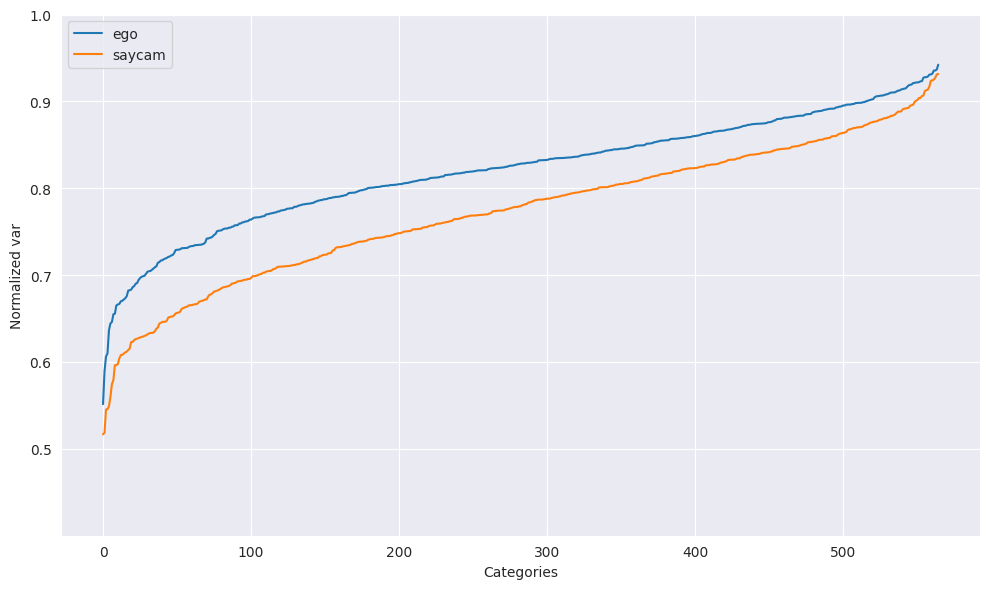

ego
['1073_fireworks' '0156_moon' '0089_bus' '2144_newsstand' '0812_coin'
 '0005_house' '2400_geyser' '0082_kitchen' '0266_gravel' '0009_car'
 '1043_mall' '2098_odometer' '1367_sphinx' '2112_photocopier'
 '0857_waterfall' '0617_taco' '0847_jaguar' '1156_nacho' '0093_pizza'
 '1933_flashbulb']
saycam
['0089_bus' '1073_fireworks' '1612_forklift' '2144_newsstand'
 '0082_kitchen' '0005_house' '2400_geyser' '1043_mall' '0009_car'
 '2112_photocopier' '1367_sphinx' '1515_waterspout' '0857_waterfall'
 '0156_moon' '0443_snowplow' '1933_flashbulb' '0149_truck' '2972_rainbow'
 '0508_croissant' '0265_steak']
['0875_broom' '0361_bucket' '0312_dustpan' '0846_pencil' '0533_seashell'
 '1704_burner' '0511_needle' '0045_ball' '0359_shovel' '2338_bolt'
 '0740_worm' '0767_padlock' '0158_blanket' '1385_doormat' '0877_ladle'
 '0955_cane' '2002_wand' '1635_paintbrush' '0052_fish' '1470_syringe']
['1385_doormat' '0359_shovel' '2338_bolt' '0389_ashtray' '0877_ladle'
 '1704_burner' '1475_hanger' '0553_paperclip'

In [13]:
max_rsa.plot_stats_one(compactness,models,  ['Categories', 'Normalized var'])
for model in models:
    print(f'{model}')
    print(compact_categories[model][:20])
for model in models:
    print(compact_categories[model][-20:])


In [14]:
def check_list_similarity(list1, list2):
    '''Checks if two lists contain the same elements, regardless of order,
    and calculates the proportion of common elements.'''
    set1 = set(list1)
    set2 = set(list2)
    common_elements = set1 & set2  # Intersection of sets
    proportion = (len(common_elements) / max(len(set1), len(set2))) * 100 if max(len(set1), len(set2)) > 0 else 0
    return proportion

print('\nSimilarities saycam and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories['saycam'][:50],compact_categories[model][:50]))

print('\nSimilarities ego and the others')
for model in models[:]:
    print(check_list_similarity(compact_categories['ego'][:50],compact_categories[model][:50]))


Similarities saycam and the others
82.0
100.0

Similarities ego and the others
100.0
82.0


In [15]:
### Compute 500 random sequence for significance
# initialize sequences
nb_trials = 500
idx_vec = np.array(range(len(listcat)))
mat_vec = np.zeros((nb_trials, len(idx_vec)))
for i in range(nb_trials):
    np.random.shuffle(idx_vec)
    mat_vec[i] = idx_vec

#Compute all possible similarity pairs
list_sim = []
for i in range(len(mat_vec)-1):
    for j in range(i+1,len(mat_vec)):
        list_sim.append(check_list_similarity(list(mat_vec[i][:50]), list(mat_vec[j][:50])))

# Compute 95 percentile
confinter = np.percentile(list_sim, 95)
print(f'The 95% confidence interval is:{confinter}')

The 95% confidence interval is:16.0


In [16]:
nb_categories = len(listcat)
labels, sortedmaxdiffcats, maxdiffs = max_rsa.max_compactness_difference(compact_categories, compactness, nb_categories, listcat, models = ['ego', 'saycam'], nb_max_compactness = 20)

The 20 categories leading to the max differences between ego and saycam are ['0116_flower' '0310_thimble' '0517_bumblebee' '0836_chalk' '0375_drum'
 '0630_omelet' '0852_rhino' '0822_grasshopper' '0353_whale'
 '0657_jellyfish' '0294_cauliflower' '0224_carrot' '0625_emerald'
 '0038_book' '0844_screwdriver' '0131_wall' '0157_milk' '0743_candy'
 '1593_wire' '0234_bagel']
Category numbers are [ 36 117 186 256 140 210 263 253 132 219 112  84 209   7 259  41  55 239
 430  88]
With differences in compactness of  [0.164711   0.14220566 0.12598032 0.11924076 0.11589146 0.11304265
 0.11156839 0.11063814 0.11056584 0.1100623  0.10837138 0.107449
 0.1066314  0.10602885 0.10521281 0.104536   0.10428649 0.10378969
 0.1022808  0.10227424]


In [17]:
from itertools import combinations
def find_max_dissimilarity_images(RDMs, models, categories, nb_per_cat,
                                  images_per_subset=4):
    """
    Find the subset of images per category that maximizes RDM dissimilarity between two models.

    Parameters:
    -----------
    cat_activations : dict
        Dictionary with structure: cat_activations[model][category] = array of activations (n_images, n_features)
    models : list
        List of two model names, e.g., ['model1', 'model2']
    categories : list
        List of category names/indices
    compute_RDM : function
        Function that takes activations and returns RDM: RDM = compute_RDM(activations)
    compute_similarity : function
        Function that takes two RDMs and returns similarity: sim = compute_similarity(RDM1, RDM2)
    images_per_subset : int
        Number of images to select per category (default: 4)
    method : str
        'exhaustive' or 'random' sampling of combinations

    Returns:
    --------
    results : dict
        Dictionary with results for each category:
        {
            category: {
                'best_indices': array of selected image indices,
                'max_dissimilarity': maximum dissimilarity value,
                'model1_rdm': RDM for model1 with selected images,
                'model2_rdm': RDM for model2 with selected images,
                'similarity': similarity between the two RDMs
            }
        }
    """

    if len(models) != 2:
        raise ValueError("This function requires exactly 2 models")

    results = {}

    means = {}
    n = len(RDMs[models[0]])
    upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
    means['x'] = np.mean(RDMs[models[0]][upper_indices])
    means['y'] = np.mean(RDMs[models[1]][upper_indices])
    means['norm'] = np.std(RDMs[models[0]][upper_indices]) * np.std(RDMs[models[1]][upper_indices])
    print(means)
    for category in tqdm_notebook(categories, desc="Processing categories"):
        print(f"\nProcessing category: {category}")
        # Get activations for both models for this category
        RDM1 = RDMs[models[0]][category*nb_per_cat:(category+1)*nb_per_cat, category*nb_per_cat:(category+1)*nb_per_cat]  # Shape: (50, 50)
        RDM2 = RDMs[models[1]][category*nb_per_cat:(category+1)*nb_per_cat, category*nb_per_cat:(category+1)*nb_per_cat]  # Shape: (50, 50)

        # Generate combinations of image indices
        all_combinations = list(combinations(range(nb_per_cat), images_per_subset))

        print(f"Testing {len(all_combinations)} combinations of {images_per_subset} images")

        best_indices = None
        best_model1_rdm = None
        best_model2_rdm = None
        best_similarity = 1

        # Test each combination
        for combination in tqdm_notebook(all_combinations, desc="Testing combinations", leave=False, position=1):
            indices = np.array(combination)
            # Get subset of activations
            rdm1 = RDM1[np.ix_(indices, indices)]  # Shape: (4, 4)
            rdm2 = RDM2[np.ix_(indices, indices)]  # Shape: (4, 4s)

            # Compute similarity between RDMs

            similarity = rsa.Compute_sim_RDMs(rdm1, rdm2, center = False, metric = 'pearson_global', means= means)

            # Update best if this is better
            if similarity < best_similarity:
                best_indices = indices
                best_model1_rdm = rdm1
                best_model2_rdm = rdm2
                best_similarity = similarity

        # Store results for this category
        results[category] = {
            'best_indices': best_indices,
            'model1_rdm': best_model1_rdm,
            'model2_rdm': best_model2_rdm,
            'similarity': best_similarity
        }

        print(f"Best indices for {category}: {best_indices}")
        print(f"Similarity: {best_similarity:.4f}")

    return results

results = find_max_dissimilarity_images(
        RDMs, ['ego', 'saycam'], labels[:10], 50,
        images_per_subset=4
    )

{'x': np.float32(1.5041226), 'y': np.float32(1.1682364), 'norm': np.float32(0.014819883)}


Processing categories:   0%|          | 0/10 [00:00<?, ?it/s]


Processing category: 36
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 36: [11 19 33 43]
Similarity: -1.3398

Processing category: 117
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 117: [ 1 13 32 41]
Similarity: -0.6291

Processing category: 186
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 186: [ 0  9 10 26]
Similarity: -0.7191

Processing category: 256
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 256: [12 14 34 38]
Similarity: -0.9217

Processing category: 140
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 140: [ 1  8 34 38]
Similarity: -0.6864

Processing category: 210
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 210: [14 36 37 48]
Similarity: -0.9422

Processing category: 263
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 263: [ 0 14 25 30]
Similarity: -0.5603

Processing category: 253
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 253: [19 39 40 45]
Similarity: -0.7357

Processing category: 132
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 132: [18 33 42 47]
Similarity: -0.6592

Processing category: 219
Testing 230300 combinations of 4 images


Testing combinations:   0%|          | 0/230300 [00:00<?, ?it/s]

Best indices for 219: [10 16 20 30]
Similarity: -1.3707


In [18]:
def compute_sub_rdm_similarity(results, full_rdms, models, categories):
    """
    Compute sub-RDMs using the 40 selected images (4 per category × 10 categories)
    that maximize dissimilarity between models, then compute their similarity.

    Parameters:
    -----------
    results : dict
        Output from find_max_dissimilarity_images() with structure:
        results[category]['best_indices'] = array of 4 selected image indices
    full_rdms : dict
        Dictionary: full_rdms[model] = full RDM array (25000, 25000)
    models : list
        List of two model names, e.g., ['model1', 'model2']
    categories : list
        List of category names/indices (should have 10 categories)

    Returns:
    --------
    result : dict
        Dictionary containing:
        {
            'similarity': similarity between the two 40×40 RDMs,
            'model1_rdm': 40×40 RDM for model1,
            'model2_rdm': 40×40 RDM for model2,
            'image_info': list of (category, original_index) for each of the 40 images
        }
    """

    if len(models) != 2:
        raise ValueError("This function requires exactly 2 models")

    print(f"Collecting 40 selected images from {len(categories)} categories...")

    means = {}
    n = len(RDMs[models[0]])
    upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
    means['x'] = np.mean(RDMs[models[0]][upper_indices])
    means['y'] = np.mean(RDMs[models[1]][upper_indices])
    means['norm'] = np.std(RDMs[models[0]][upper_indices]) * np.std(RDMs[models[1]][upper_indices])
    # Collect selected image indices from all categories
    selected_indices = []
    image_info = []  # Track which category and original index each image comes from

    total_selected = 0

    for category in categories:
        if category not in results:
            raise ValueError(f"Category {category} not found in results")

        # Get the 4 selected indices for this category
        cat_selected_indices = results[category]['best_indices']

        if len(cat_selected_indices) != 4:
            print(f"Warning: Category {category} has {len(cat_selected_indices)} images instead of 4")

        # Add to combined list
        selected_indices.extend(cat_selected_indices + 50*category)

        # Track image information
        for idx in cat_selected_indices:
            image_info.append((category, idx))

        total_selected += len(cat_selected_indices)
        print(f"Category {category}: selected indices {cat_selected_indices}")

    print(f"\nTotal selected images: {total_selected}")

    # Verify we have 40 images
    if len(selected_indices) != 40:
        print(f"Warning: Expected 40 images, got {len(selected_indices)}")

    # Extract sub-RDMs for both models using the 40 selected images
    print("Extracting sub-RDMs...")
    rdm_model1 = full_rdms[models[0]][np.ix_(selected_indices , selected_indices )]  # Shape: (40, 40)
    rdm_model2 = full_rdms[models[1]][np.ix_(selected_indices , selected_indices  )]  # Shape: (40, 40)

    print(f"RDM shapes: {rdm_model1.shape}, {rdm_model2.shape}")

    # Compute similarity between the two RDMs
    print("Computing similarity between RDMs...")
    similarity = rsa.Compute_sim_RDMs(rdm_model1, rdm_model2, center = False, metric = 'pearson_global', means = means)

    print(f"\nRDM similarity using 40 maximally dissimilar images: {similarity:.6f}")

    # Package results
    result = {
        'similarity': similarity,
        'model1_rdm': rdm_model1,
        'model2_rdm': rdm_model2,
        'image_info': image_info,
        'total_images': total_selected,
        'selected_indices': selected_indices
    }

    fig, subs = plt.subplots(1,2)
    sns.heatmap(rdm_model1,
                annot=False,
                cmap='Greys',      # Blue to red colormap
                square=True,
                cbar=True,
                #cbar_kws={'label': 'Dissimilarity'},
                #fmt='.2f',
                linewidths=0,
                ax = subs[0],
                vmin=0,               # Set minimum value for color scale
                vmax=np.max(rdm_model1))               # Set maximum value for color scale
    sns.heatmap(rdm_model2,
                annot=False,
                cmap='Greys',      # Blue to red colormap
                square=True,
                cbar=True,
                #cbar_kws={'label': 'Dissimilarity'},
                #fmt='.2f',
                linewidths=0,
                ax = subs[1],
                vmin=0,               # Set minimum value for color scale
                vmax=np.max(rdm_model2))


    subs[0].axis('off')
    subs[1].axis('off')
    fig.tight_layout()
    plt.show()
    return result

Category 36: selected indices [11 19 33 43]
Category 117: selected indices [ 1 13 32 41]
Category 186: selected indices [ 0  9 10 26]
Category 256: selected indices [12 14 34 38]
Category 140: selected indices [ 1  8 34 38]
Category 210: selected indices [14 36 37 48]
Category 263: selected indices [ 0 14 25 30]
Category 253: selected indices [19 39 40 45]
Category 132: selected indices [18 33 42 47]
Category 219: selected indices [10 16 20 30]

Total selected images: 40
Extracting sub-RDMs...
RDM shapes: (40, 40), (40, 40)
Computing similarity between RDMs...

RDM similarity using 40 maximally dissimilar images: 0.411737


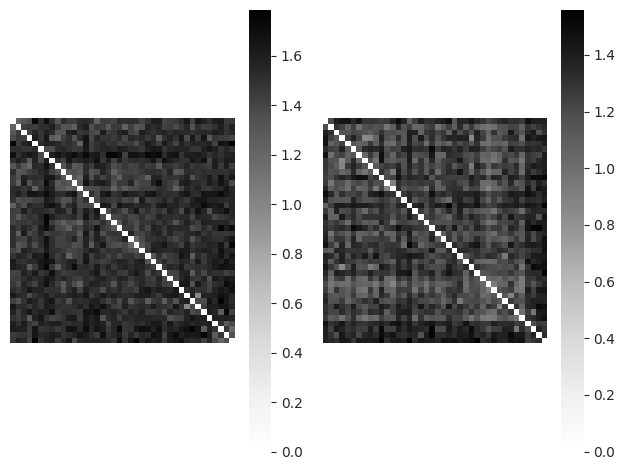

In [19]:
similarity_dict = compute_sub_rdm_similarity(results, RDMs, ['ego', 'saycam'], labels[:10])


In [24]:

def sample_rdm_pairs(RDM1, RDM2, n_samples=100000, subset_size=40,
                                    batch_size=10000, seed=None):
    """
    Memory-efficient version that processes in batches and optionally saves to disk.

    Parameters:
    -----------
    batch_size : int
        Number of samples to process at once (default: 1000)
    output_file : str, optional
        If provided, saves results to this file using pickle
    """

    if seed is not None:
        np.random.seed(seed)

    n_images = RDM1.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size

    all_sims_samples = []
    all_indices = []
    means = {}
    n = len(RDMs[models[0]])
    upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
    means['x'] = np.mean(RDM1[upper_indices])
    means['y'] = np.mean(RDM2[upper_indices])
    means['norm'] = np.std(RDMs[models[0]][upper_indices]) * np.std(RDMs[models[1]][upper_indices])
    print(f"Processing {n_samples} samples in {n_batches} batches of {batch_size}...")

    for batch_idx in tqdm_notebook(range(n_batches)):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, n_samples)
        current_batch_size = end_idx - start_idx

        # Allocate batch arrays
        batch_sim = np.zeros((current_batch_size))
        batch_indices = np.zeros((current_batch_size, subset_size), dtype=int)

        for i in range(current_batch_size):
            # Randomly select images
            indices = np.random.choice(n_images, size=subset_size, replace=False)
            indices = np.sort(indices)

            # Extract submatrices
            batch_sim[i] = rsa.Compute_sim_RDMs(RDM1[np.ix_(indices, indices)], RDM2[np.ix_(indices, indices)], center = False, metric = 'pearson' )
            batch_indices[i] = indices

        all_sims_samples.append(batch_sim)
        all_indices.append(batch_indices)

    # Concatenate all batches
    sim_samples = np.concatenate(all_sims_samples, axis=0)
    indices_used = np.concatenate(all_indices, axis=0)


    return sim_samples, indices_used

sim_samples, indices_used = sample_rdm_pairs(RDMs['ego'], RDMs['saycam'], n_samples=1000000, subset_size=40,
                                    batch_size=1000, seed=None)


Processing 1000000 samples in 1000 batches of 1000...


  0%|          | 0/1000 [00:00<?, ?it/s]

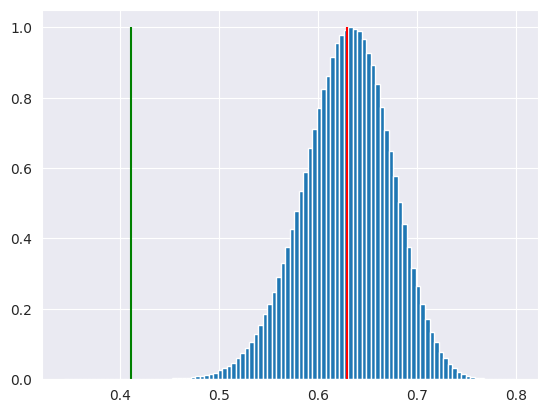

In [25]:
hist, bin_edges = np.histogram(sim_samples, 100)
plt.bar(bin_edges[:-1],hist/max(hist), width = bin_edges[1] - bin_edges[0], align = 'edge')
plt.vlines(similarity_dict['similarity'], 0, 1, 'green')
plt.vlines(SIMs_saycam_ego, 0, 1, 'r')
plt.show()
perc = np.sum(sim_samples< similarity_dict['similarity'])/len(sim_samples)


In [28]:
perc*len(sim_samples)

np.float64(13.0)

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

def display_low_similarity_images(image_paths, indices_vectorized, n_images=40,
                                 grid_cols=8, figsize=(20, 10), save_path=None):
    """
    Load and display the first n images corresponding to lowest similarity indices.

    Parameters:
    -----------
    image_paths : list
        List of image file paths matching the RDM column indices
    indices_vectorized : numpy.ndarray
        Column indices sorted from lowest to highest similarity
    n_images : int
        Number of images to display (default: 40)
    grid_cols : int
        Number of columns in the display grid (default: 8)
    figsize : tuple
        Figure size for matplotlib (default: (20, 10))
    save_path : str, optional
        Path to save the figure (if None, just display)

    Returns:
    --------
    loaded_images : list
        List of loaded images (as numpy arrays)
    valid_paths : list
        List of valid image paths that were successfully loaded
    """

    # Get the indices for the first n_images with lowest similarity
    low_similarity_indices = indices_vectorized[:n_images]

    # Get corresponding image paths
    selected_paths = [image_paths[idx] for idx in low_similarity_indices]

    loaded_images = []
    valid_paths = []
    valid_indices = []

    print(f"Loading {n_images} images with lowest RDM column similarity...")

    # Load images
    for i, (path, orig_idx) in enumerate(zip(selected_paths, low_similarity_indices)):
        try:
            # Check if file exists
            if not os.path.exists(path):
                print(f"Warning: File not found: {path}")
                continue

            # Load image with cv2
            img = cv2.imread(path)

            if img is None:
                print(f"Warning: Could not load image: {path}")
                continue

            # Convert BGR to RGB for matplotlib display
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            loaded_images.append(img_rgb)
            valid_paths.append(path)
            valid_indices.append(orig_idx)

        except Exception as e:
            print(f"Error loading {path}: {e}")
            continue

    print(f"Successfully loaded {len(loaded_images)} out of {n_images} requested images")

    if len(loaded_images) == 0:
        print("No images could be loaded!")
        return [], []

    # Calculate grid dimensions
    n_loaded = len(loaded_images)
    grid_rows = (n_loaded + grid_cols - 1) // grid_cols

    # Create figure and display images
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=figsize)
    fig.suptitle(f'Images leading to lowest similarity',
                 fontsize=16, y=0.98)

    # Handle case where we have only one row
    if grid_rows == 1:
        axes = axes.reshape(1, -1)

    for i in range(grid_rows * grid_cols):
        row = i // grid_cols
        col = i % grid_cols
        ax = axes[row, col]

        if i < len(loaded_images):
            # Display image
            ax.imshow(loaded_images[i])

            # Add title with original index and filename
            filename = Path(valid_paths[i]).name
            label = valid_paths[i].split('/')[-2]
            ax.set_title(f'Label: {label }\n{filename[:20]}...',
                        fontsize=8, pad=2)

        ax.axis('off')

    plt.tight_layout()

    # Save or show
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()

    return loaded_images, valid_paths

Loading 40 images with lowest RDM column similarity...
Successfully loaded 40 out of 40 requested images
Figure saved to: figures/images_inverse_Fisher_descriminant.png


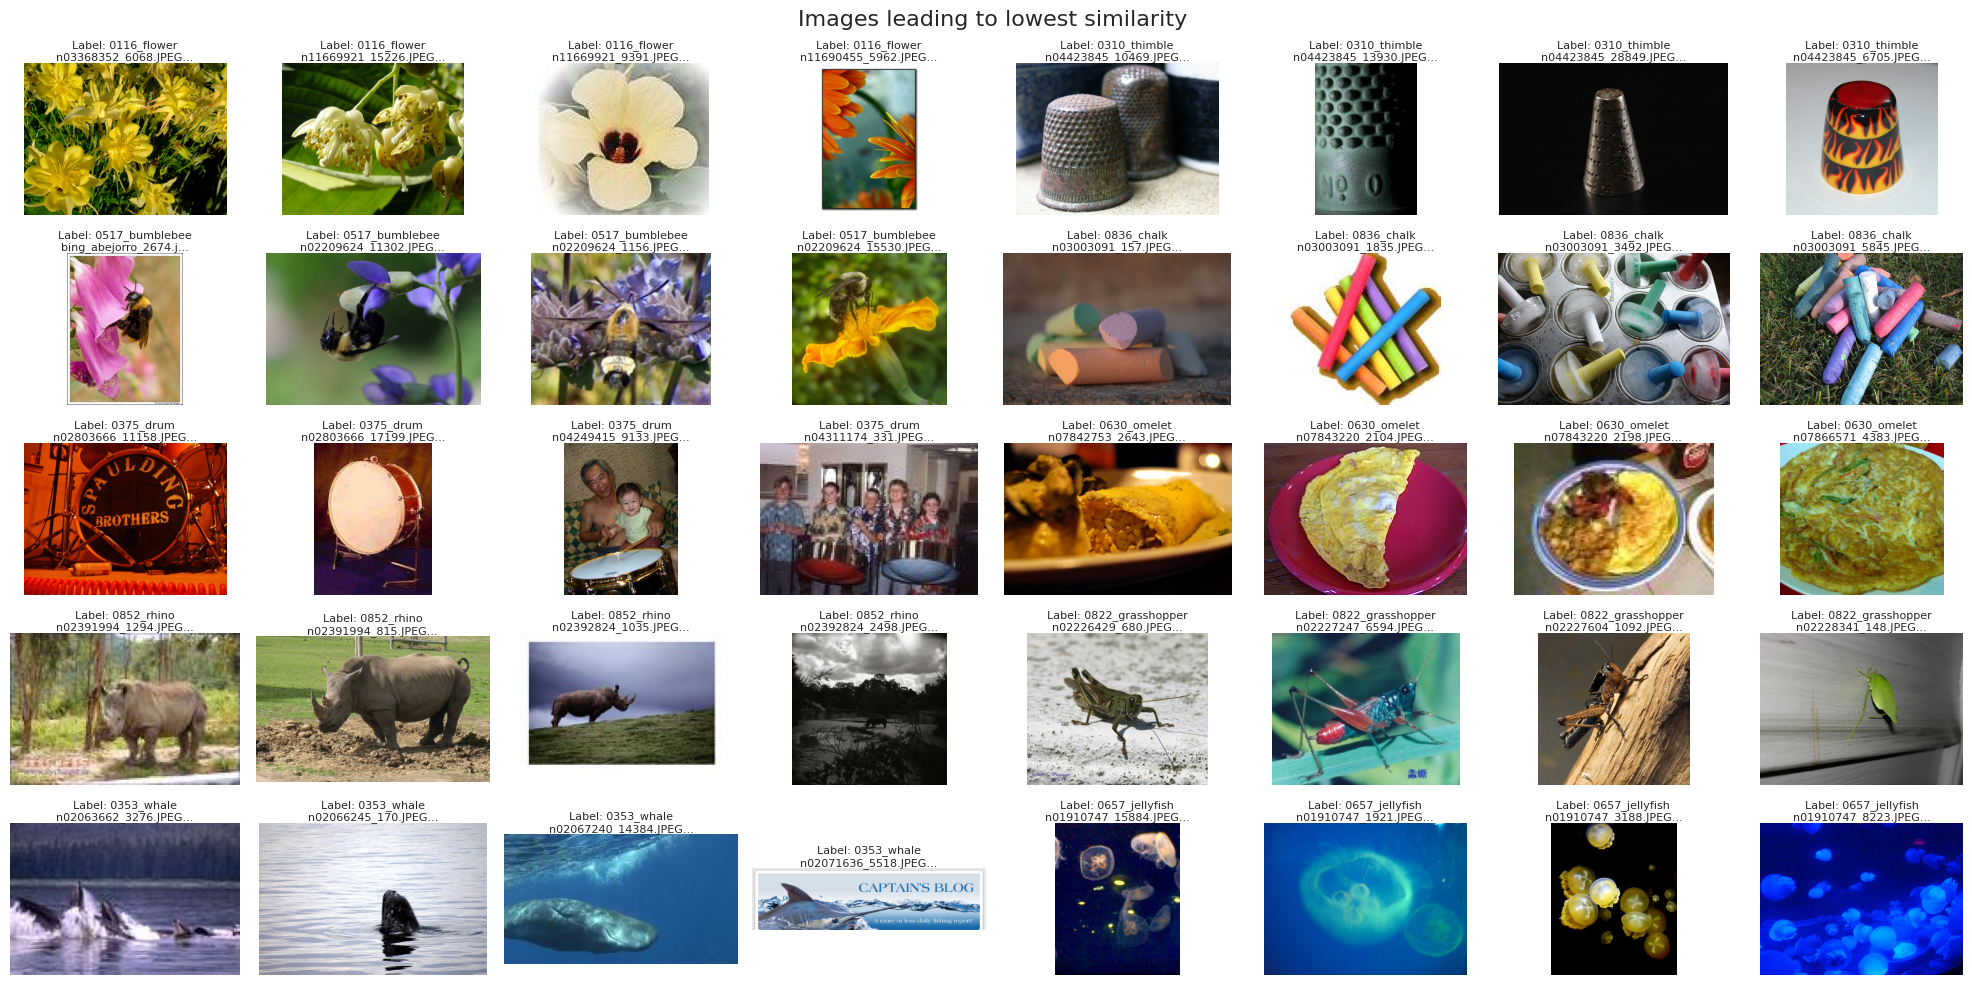

In [31]:
imagelist = [img.replace('/raid/shared/datasets/visoin/', '/home/alban/Documents/') for img in imagelist]
images, paths = display_low_similarity_images(imagelist, similarity_dict['selected_indices'], n_images=40,
                                 grid_cols=8, figsize=(20, 10), save_path='figures/images_inverse_Fisher_descriminant.png')